# Tanzanian Water Well's Status Predictions

#### Authors: Kyle Dufrane and Brad Horn

### Overview

#### This project analyzes the Tanzanian Water Wells datasets released by the Tanzanian Government. The dataset includes 59,400 rows each repressenting a unique well within the Tanzanian Governments realm. Our targets are broken down into three categories:

* Functional
* Non Functional
* Functional Needs Repair

#### We will attempt to predict the status of the wells condition through utilizing Exploratory Data Analysis (EDA) and building classification models tuned to the parameters that will have the largest impact on our predictive ability. 


### Business Understanding

#### Flatiron LLC has recently been awarded a contract to maintain wells in Tanzania. They're looking for a system to help develop preventative maintenance schedules by predicting pump failures and replacement schedules to better serve their client. Flatiron LLC would like key insights on:

* Regional impact on wells
* Area's with low water quantity
* Negatively impacting factors on wells 


### Data Understanding

#### This dataset comes with two applicable files training_set_labels and training_set_values. During our EDA we will join these tables together to give us one file to work with. The values dataset has 39 total columns and contains all of our predicitve features. Below is a description of each column. 

* amount_tsh : Total static head (amount water available to waterpoint)
* date_recorded : The date the row was entered
* funder : Who funded the well
* gps_height : Altitude of the well
* installer : Organization that installed the well
* longitude : GPS coordinate
* latitude : GPS coordinate
* wpt_name : Name of the waterpoint if there is one
* num_private :Private use or not
* basin : Geographic water basin
* subvillage : Geographic location
* region : Geographic location
* region_code : Geographic location (coded)
* district_code : Geographic location (coded)
* lga : Geographic location
* ward : Geographic location
* population : Population around the well
* public_meeting : True/False
* recorded_by : Group entering this row of data
* scheme_management : Who operates the waterpoint
* scheme_name : Who operates the waterpoint
* permit : If the waterpoint is permitted
* construction_year : Year the waterpoint was constructed
* extraction_type : The kind of extraction the waterpoint uses
* extraction_type_group : The kind of extraction the waterpoint uses
* extraction_type_class : The kind of extraction the waterpoint uses
* management : How the waterpoint is managed
* management_group : How the waterpoint is managed
* payment : What the water costs
* payment_type : What the water costs
* water_quality : The quality of the water
* quality_group : The quality of the water
* quantity : The quantity of water
* quantity_group : The quantity of water
* source : The source of the water
* source_type : The source of the water
* source_class : The source of the water
* waterpoint_type : The kind of waterpoint
* waterpoint_type_group : The kind of waterpoint

#### To start we will import all of our needed libraries and dive into our datasets.

In [1]:
# Import needed libraries

# Import libaries needed for EDA and visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Import Pickle to saved files giving us the ability to only run each model once.
import pickle

# Import needed SKLearn libraries for modeling, imputing, and pipelines
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from xgboost import XGBClassifier

# Import YellowBrick to easily plot ROC AUC curves on multiclass algorithms
from yellowbrick.classifier import ROCAUC

#Import py files
#Use the functions in the py file for preprocessing
import sys
sys.path.insert(0, 'src/')
import functions

pd.set_option('display.max_columns', 999)

### Import and basic interpretation on our datasets

In [2]:
# Import training labels CSV
df_training_labels = pd.read_csv('data/Training_set_labels.csv')

In [3]:
df_training_labels.shape

(59400, 2)

In [4]:
df_training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
df_training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [6]:
df_training_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

#### Revewing the above information we do not have any nulls in our this dataset which is a good start as these are our targets. We can see that this dataset has two columns, one of which being 'id'. Hopefully we can use this to join our tables later in the EDA process. 

#### The big catch here is seeing the **class imbalance**, we will have to adjust our model accordingly to make up for the lack of values especially within the 'functional needs repair' category. 

### Now we'll review our predictors within the Training_set_values.cvs

In [7]:
# Import training values CSV
df_training_values = pd.read_csv('data/Training_set_values.csv')

In [8]:
df_training_values.shape

(59400, 40)

In [9]:
df_training_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

#### Reviewing the above output, we have a few columns with Null values. Going forward we will review these columns and identify the appropriate way to either replace or drop these columns. Also, we can see that we have an 'id' column which should allow us to join our tables. 

#### Below we will get a clearer understanding of what columns are missing columns. 

In [10]:
df_training_values.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

#### Out of the 39 features 7 of them are missing values. A few items stand out:

* Funder and installer have close to equal amounts of missing values
* subvillage has the least amount of missing values
* scheme_name is missing almost half of the values

#### Since scheme name is missing half of the data we will drop this column as it will not have a significant impact on our model. 

In [11]:
# Dropping column from dataframe
df_training_values.drop('scheme_name', axis = 1, inplace = True)

#### As seen above, 7 columns are missing data. Lets take a deeper look into these columns. 

In [12]:
# Creating a list of columns with missing values
missing_values = ['funder', 'installer', 'subvillage', 'public_meeting',\
                  'scheme_management', 'permit']

# Creating a dataframe with above missing_values
df_training_values[missing_values]

,funder,installer,subvillage,public_meeting,scheme_management,permit
0,Roman,Roman,Mnyusi B,True,VWC,False
1,Grumeti,GRUMETI,Nyamara,NaN,Other,True
2,Lottery Club,World vision,Majengo,True,VWC,True
3,Unicef,UNICEF,Mahakamani,True,VWC,True
4,Action In A,Artisan,Kyanyamisa,True,NaN,True
...,...,...,...,...,...,...
59395,Germany Republi,CES,Kiduruni,True,Water Board,True
59396,Cefa-njombe,Cefa,Igumbilo,True,VWC,True
59397,NaN,NaN,Madungulu,True,VWC,False
59398,Malec,Musa,Mwinyi,True,VWC,True


In [13]:
df_training_values[missing_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   funder             55765 non-null  object
 1   installer          55745 non-null  object
 2   subvillage         59029 non-null  object
 3   public_meeting     56066 non-null  object
 4   scheme_management  55523 non-null  object
 5   permit             56344 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB


In [14]:
df_training_values[missing_values].isna().sum()

funder               3635
installer            3655
subvillage            371
public_meeting       3334
scheme_management    3877
permit               3056
dtype: int64

#### We can now see that all of these features are of the dtype object which narrows down our options to dealing with the missing values. What are these features composed of? 

#### To start, lets take a look at our previous mentioned insite of funders and installers having close to the same amount of missing values. 

In [15]:
df_training_values[df_training_values['funder'].isna()]['installer'].isna().value_counts()

True     3582
False      53
Name: installer, dtype: int64

In [16]:
df_training_values[df_training_values['installer'].isna()]['funder'].isna().value_counts()

True     3582
False      73
Name: funder, dtype: int64

#### Looking at the above counts we can compare when one value is null how it effects the other value within the dateframe. 

#### I.E. when 'funder' is null within the dataframe how many of the 'installers' are also labels as null. Above we can see that 3582 are 'installers' are labeled as null while 53 contain and actual value. 

#### With this information we will move forward working with these columns independently of one another.

### Funder:

In [17]:
df_training_values['funder'].value_counts()

Government Of Tanzania          9084
Danida                          3114
Hesawa                          2202
Rwssp                           1374
World Bank                      1349
                                ... 
Males                              1
Taes                               1
Charlotte Well                     1
Idf                                1
Kitiangare Village Community       1
Name: funder, Length: 1897, dtype: int64

In [18]:
df_training_values[df_training_values['funder'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,GeoData Consultants Ltd,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,GeoData Consultants Ltd,VWC,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,GeoData Consultants Ltd,VWC,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,Rufiji,Lembuka,Mbeya,12,7,Mbarali,Mawindi,0,True,GeoData Consultants Ltd,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,GeoData Consultants Ltd,VWC,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,GeoData Consultants Ltd,VWC,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,GeoData Consultants Ltd,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59376,34716,0.0,2013-02-03,NaN,1581,NaN,34.821039,-5.076258,Nasingo,0,Internal,Hu,Singida,13,2,Singida Rural,Dung'unyi,1,True,GeoData Consultants Ltd,VWC,NaN,1990,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other


#### The 'recorded_by' column contains 'GeoData Consultants Ltd' in each row. Lets take a deeper look at this and see if we are able to drop this row due to a single value. 

### Recorded_by:

In [19]:
df_training_values['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

#### With only one value for this column it will not have any effect on our model and are able to drop this column.

In [20]:
df_training_values.drop('recorded_by', axis = 1, inplace = True)

### Installer

In [21]:
df_training_values['installer'].value_counts()

DWE           17402
Government     1825
RWE            1206
Commu          1060
DANIDA         1050
              ...  
Mr Chi            1
GRUMENTI          1
AGRICAN           1
HESAW             1
Juma              1
Name: installer, Length: 2145, dtype: int64

In [22]:
df_training_values[df_training_values['installer'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,VWC,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,VWC,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,Rufiji,Lembuka,Mbeya,12,7,Mbarali,Mawindi,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,VWC,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,VWC,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59376,34716,0.0,2013-02-03,NaN,1581,NaN,34.821039,-5.076258,Nasingo,0,Internal,Hu,Singida,13,2,Singida Rural,Dung'unyi,1,True,VWC,NaN,1990,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other


#### Again, reviewing the above dataframe, nothing jumps out of importance. We will continue on and conclude our null value adjustments at a later time.

### Subvillage

In [23]:
df_training_values['subvillage'].value_counts()

Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
                  ... 
Bukindo Nkokolo      1
Mwosi                1
Galangala            1
Buchemba             1
Mwitambu C           1
Name: subvillage, Length: 19287, dtype: int64

In [24]:
df_training_values[df_training_values['subvillage'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
342,21127,0.0,2011-03-16,Government Of Tanzania,0,North,36.557631,-6.233394,Kwa Mihinzo,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Sagara,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe multiple,communal standpipe
360,51558,0.0,2011-03-25,Commu,0,Commu,36.416701,-6.220157,Kwa Emanuel,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Kongwa Urban,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe
379,53847,0.0,2011-03-20,World Bank,0,Rhobi,36.729383,-6.084255,Kwa Dimanyi,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,VWC,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
565,27334,0.0,2011-03-18,World Bank,0,Rhoda,36.696881,-5.993192,Mpande,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Njoge,0,True,VWC,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
966,17088,0.0,2011-03-11,Water,0,Commu,36.322623,-6.030500,Kwa Charles,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Sejeli,0,True,VWC,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59008,16353,0.0,2011-03-23,Commu,0,Commu,36.770490,-6.288555,Kwa Mlima,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Mlali,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
59091,45206,0.0,2011-03-14,Lvia,0,Commu,36.407974,-5.715084,Kwa Emson,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Zoissa,0,True,VWC,False,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
59105,12248,0.0,2011-03-19,World Bank,0,Rhobi,36.889359,-5.959966,Kwa Mahimbo,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,VWC,False,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
59215,46441,0.0,2011-03-19,World Bank,0,Rhobi,36.854216,-6.010508,Kwa Sila,0,Wami / Ruvu,NaN,Dodoma,1,3,Kongwa,Pandambili,0,True,VWC,False,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


#### One observation I found was that the 'region' contains 'Dodoma' multiple times. Lets look at the value counts for this.  

In [25]:
df_training_values[df_training_values['subvillage'].isna()]['region'].value_counts()

Dodoma    361
Mwanza     10
Name: region, dtype: int64

#### With Dodoma being the majority value here we will keep this in mind when replacing the values later on. 

### Public Meeting:

In [26]:
df_training_values['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [27]:
df_training_values[df_training_values['public_meeting'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466e+00,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
18,34169,0.0,2011-07-22,Hesawa,1162,DWE,32.920154,-1.947868e+00,Ngomee,0,Lake Victoria,Center,Mwanza,19,1,Ukerewe,Ilangala,1000,NaN,NaN,True,1999,other,other,other,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,spring,spring,groundwater,other,other
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.000000,-2.000000e-08,Muungano,0,Lake Victoria,Ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,0,NaN,WUG,False,0,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump
58,24593,0.0,2013-01-22,Kkkt,1703,KKKT,35.561346,-3.806879e+00,Kwa Iyora Mgirigisi,0,Internal,Ants B,Manyara,21,3,Mbulu,Bargish,456,NaN,WUG,True,2000,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
73,35715,0.0,2013-02-27,Hesawa,1565,HESAWA,34.657034,-1.888020e+00,Machumbe,0,Lake Victoria,Mtakuja,Mara,20,2,Serengeti,Manchira,200,NaN,Other,True,1991,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59306,71419,0.0,2013-01-16,Cocern,1296,TWESA,30.930385,-3.300592e+00,Kwa Mhunda,0,Lake Tanganyika,Nguvu Kazi A,Kigoma,16,1,Kibondo,Kakonko,1,NaN,NaN,False,2013,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,improved spring,improved spring
59310,32815,0.0,2013-04-04,Tasaf,892,TASAF,37.744090,-4.062296e+00,Ward Office,0,Pangani,Same,Kilimanjaro,3,3,Same,Same Urban,65,NaN,NaN,NaN,0,other,other,other,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.000000,-2.000000e-08,Mwazwilo,0,Lake Victoria,Mbita,Shinyanga,17,1,Bariadi,Mbita,0,NaN,WUG,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
59344,6450,0.0,2013-10-03,NaN,1303,NaN,36.900911,-3.111477e+00,Pentecoste Swidish,0,Internal,Madukani,Arusha,2,7,Meru,Ngarenanyuki,230,NaN,NaN,NaN,0,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe


#### Again, reviewing the above dataframe, nothing jumps out of importance. We will continue on and conclude our null value adjustments at a later time.

In [28]:
df_training_values['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [29]:
df_training_values[df_training_values['scheme_management'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
18,34169,0.0,2011-07-22,Hesawa,1162,DWE,32.920154,-1.947868,Ngomee,0,Lake Victoria,Center,Mwanza,19,1,Ukerewe,Ilangala,1000,NaN,NaN,True,1999,other,other,other,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,spring,spring,groundwater,other,other
27,20145,0.0,2011-07-11,Hesawa,0,DWE,31.104257,-1.735361,Kwawilliam,0,Lake Victoria,Chakahaya,Kagera,18,1,Karagwe,Nyaishozi,0,True,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59329,27957,0.0,2013-02-09,Rwssp,0,DWE,32.597166,-3.812227,Kasela,0,Lake Victoria,Kasela,Shinyanga,17,3,Kahama,Malunga,0,True,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,other,other
59344,6450,0.0,2013-10-03,NaN,1303,NaN,36.900911,-3.111477,Pentecoste Swidish,0,Internal,Madukani,Arusha,2,7,Meru,Ngarenanyuki,230,NaN,NaN,NaN,0,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe
59362,18917,0.0,2011-03-02,Samlo,2190,SHIPO,34.716812,-9.537797,none,0,Lake Nyasa,Mnogelwa,Iringa,11,4,Njombe,Luponde,60,True,NaN,False,2007,other - rope pump,rope pump,rope pump,private operator,commercial,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other


#### Again, reviewing the above dataframe, nothing jumps out of importance. We will continue on and conclude our null value adjustments at a later time.

In [30]:
df_training_values['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [31]:
df_training_values[df_training_values['permit'].isna()]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,VWC,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,VWC,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
109,7116,0.0,2011-07-12,NaN,0,NaN,33.805081,-9.130674,Kwa Mzee Kaiga,0,Lake Nyasa,Ipuguso,Mbeya,12,4,Rungwe,Lutebe,0,True,VWC,NaN,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
118,10837,0.0,2012-10-29,Hesawa,1339,Hesawa,34.448645,-2.022663,Tattabigo Shule Ya Msingi,0,Lake Victoria,Mwebebonda,Mara,20,2,Serengeti,Natta,600,False,Other,NaN,1997,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59339,1209,0.0,2011-07-08,NaN,0,NaN,33.654516,-9.312477,Kwa Mzee Gwalugano,0,Lake Nyasa,Katumba,Mbeya,12,4,Rungwe,Mpuguso,0,True,VWC,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
59344,6450,0.0,2013-10-03,NaN,1303,NaN,36.900911,-3.111477,Pentecoste Swidish,0,Internal,Madukani,Arusha,2,7,Meru,Ngarenanyuki,230,NaN,NaN,NaN,0,gravity,gravity,gravity,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,spring,spring,groundwater,communal standpipe,communal standpipe
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,VWC,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,VWC,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


#### Interesting, it looks like we have a lot of null values in the installer and funder rows. Lets get a better understanding. 

In [32]:
df_training_values[df_training_values['scheme_management'].isna()]['funder'].isna().sum()

46

In [33]:
df_training_values[df_training_values['scheme_management'].isna()]['installer'].isna().sum()

59

#### Misleading! Out of 3056 rows we have a total of 105 missing values between the two columns. I thought we were onto something but turns out this isn't an important find! 

## Data Preparation

### For each column we will create two variables for modeling. One with the mode value for each column and one with a newly created variable denoted 'other'.

In [34]:
# Creating new dataframes
df_training_val_mode = df_training_values.copy()
df_training_val_other = df_training_values.copy()

In [35]:
# Replacing values with string 'other'
functions.replace_other(df_training_val_other, missing_values)

In [36]:
# Replacing values with most prevelant value in each respective column
functions.replace_most_frequent(df_training_val_mode, missing_values)

#### Lets verify that our functions worked as intended

In [37]:
df_training_val_mode.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

In [38]:
df_training_val_other.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

#### Great! We have review the null values from both of our dataframes. Later on we will see if either value replacement has a better effect than the other. 

### Joining Tables

#### Now lets merge the tables so we only have two data sets to work with. To start, both dataframes have an ID column so we will create a new column on our target set and drop the identical column.

In [39]:
# Create new column to verify identical id numbers across the entire dataframe
df_training_labels['id_2'] = df_training_labels['id']
df_training_labels.drop('id', axis = 1, inplace = True)

#### Next we will join our tables and create two dataframes for 'mode' and 'other'

In [40]:
df_mode = pd.concat([df_training_val_mode, df_training_labels], join = 'inner', axis = 1)

df_other = pd.concat([df_training_val_other, df_training_labels], join = 'inner', axis = 1)

#### Let's verify that all id's are the same across the dataset

In [41]:
len(df_mode[df_mode['id'] == df_mode['id_2']])

59400

In [42]:
len(df_other[df_other['id'] == df_other['id_2']])

59400

#### As seen above our total rows equal that of the normal dataframe so we can conclude that our merges have been successful and we can drop our id_2 column.

In [43]:
df_mode.drop(['id_2'], axis = 1, inplace = True)
df_other.drop(['id_2'], axis = 1, inplace = True)

### Additional Columns to Drop

#### The Id columns and date_recorded can be considered admin columns and will not have much predictive power in our model therefore we will drop these columns. 

In [44]:
df_mode.drop(['id', 'date_recorded'], axis = 1, inplace = True)
df_other.drop(['id', 'date_recorded'], axis = 1, inplace = True)

### Data Preparation

#### To start with our data preparation we will create a function that allows us to see what percentage of features within a column fall within a status group. 

#### I.E. if 4141 wells in Iringa are functional out of 5294 than 78.22% of the wells in Iringa are functional as seen below. 

In [45]:
# function_df = df_mode.drop('status_group', axis = 1)

# percentage_dict = {}

# for idx, column in enumerate(function_df.columns):
#     percentage_dict[column] = get_totals(df_mode, column, 'status_group')

# pickle_out = open('percentage_dict.pickle', 'wb')
# pickle.dump(percentage_dict, pickle_out)

In [46]:
pickle_in = open('saved_code/percentage_dict.pickle', 'rb')

percentage_dict = pickle.load(pickle_in)

In [47]:
percentage_dict['region']

,status_group,region,status_group_values,status_group_total_values,status_group_percentage
0,functional,Iringa,4141,5294,0.782206
1,functional,Shinyanga,2789,4982,0.559815
2,functional,Kilimanjaro,2640,4379,0.602877
3,functional,Mbeya,2319,4639,0.499892
4,functional,Arusha,2294,3350,0.684776
...,...,...,...,...,...
58,non functional,Singida,954,2093,0.455805
59,non functional,Arusha,881,3350,0.262985
60,non functional,Kigoma,850,2816,0.301847
61,non functional,Manyara,500,1583,0.315856


#### Below we can start visualizing graphs based on our saved dictionary. Lets see if anything stands out to us.

#### Since our stakeholder is concerned with the regional impact we can start with looking at the top performers folllowed by the lowest performing regions. 

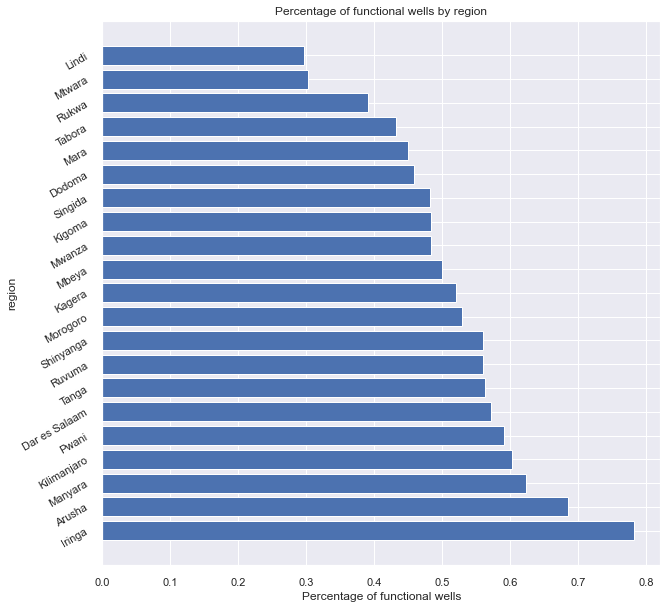

In [48]:
functions.plot_barh_def('region', 'functional')

#### We can see that Iringa is our top performer with Lindi being the poorest. What're their value counts though? Does this really mean anything?

In [49]:
percentage_dict['region'][percentage_dict['region']['status_group'] == 'functional']

,status_group,region,status_group_values,status_group_total_values,status_group_percentage
0,functional,Iringa,4141,5294,0.782206
1,functional,Shinyanga,2789,4982,0.559815
2,functional,Kilimanjaro,2640,4379,0.602877
3,functional,Mbeya,2319,4639,0.499892
4,functional,Arusha,2294,3350,0.684776
5,functional,Morogoro,2119,4006,0.528957
6,functional,Kagera,1727,3316,0.520808
7,functional,Pwani,1556,2635,0.590512
8,functional,Mwanza,1502,3102,0.484204
9,functional,Ruvuma,1480,2640,0.560606


#### All of these wells have strong value counts. This will be useful information for our stakeholder. We will now repeat the same process with non functional wells.

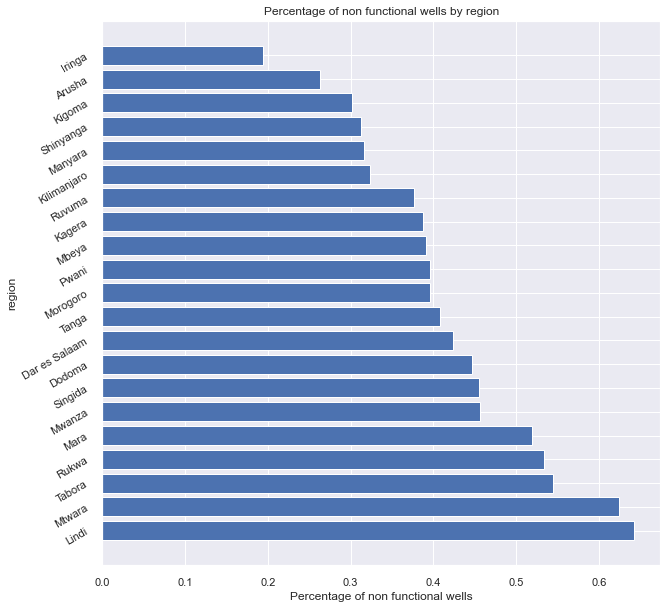

In [50]:
functions.plot_barh_def('region', 'non functional')

In [51]:
percentage_dict['region'][percentage_dict['region']['status_group'] == 'non functional']

,status_group,region,status_group_values,status_group_total_values,status_group_percentage
42,non functional,Mbeya,1816,4639,0.391464
43,non functional,Morogoro,1587,4006,0.396156
44,non functional,Shinyanga,1558,4982,0.312726
45,non functional,Kilimanjaro,1417,4379,0.323590
46,non functional,Mwanza,1417,3102,0.456802
47,non functional,Kagera,1285,3316,0.387515
48,non functional,Mtwara,1080,1730,0.624277
49,non functional,Tabora,1066,1959,0.544155
50,non functional,Pwani,1043,2635,0.395825
51,non functional,Tanga,1038,2547,0.407538


#### Again, all of these wells have strong values counts. This will be useful information for our stakeholder. We will now repeat the same process with non functional wells.

#### Our stakeholder is also intersted in water quantity and what causes poor well performance. Lets see if we can dig up any other information.

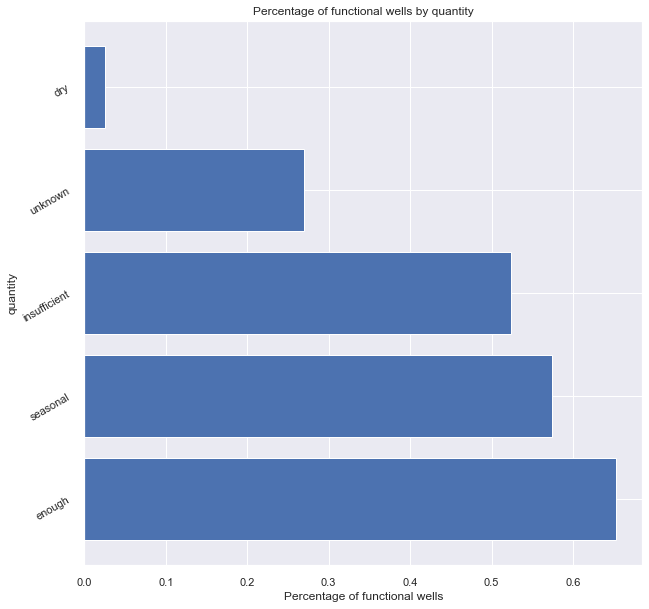

In [52]:
functions.plot_barh_def('quantity', 'functional')

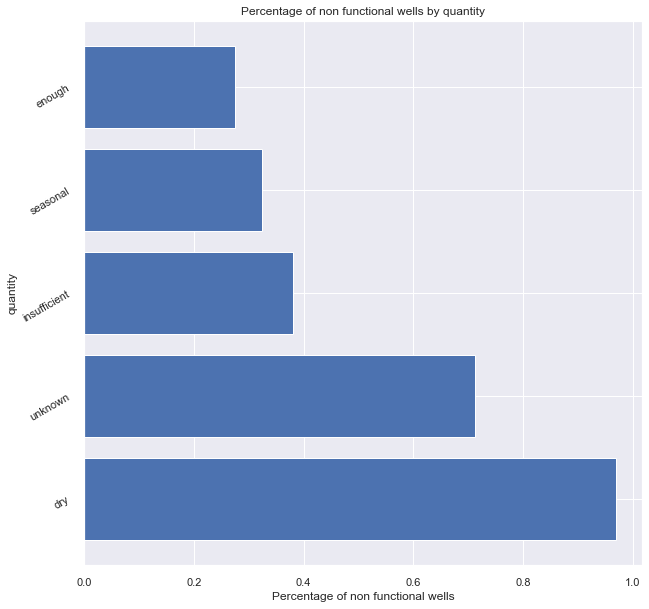

In [53]:
functions.plot_barh_def('quantity', 'non functional')

#### Unsurprisingly you need water to have a functional well. I dont think this will be much insite to our stakeholder but more of a talking point during our presentation. 

## Modeling

### First Simple Model

#### To start our modeling process we will use only our integers and floats and identify if either of our data sets out performs the other. Based on our results, we will decide which model to move forward with. 

In [54]:
X_mode_fsm = df_mode.select_dtypes(['int64', 'float64'])
y_mode_fsm = df_mode['status_group']

X_other_fsm = df_other.select_dtypes(['int64','float64'])
y_other_fsm = df_other['status_group']

In [55]:
X_mode_train, X_mode_test, y_mode_train, y__mode_test = train_test_split(X_mode_fsm,y_mode_fsm, random_state = 42, stratify = y_mode_fsm)

X_other_train, X_other_test, y_other_train, y_other_test = train_test_split(X_other_fsm,y_other_fsm, random_state = 42, stratify = y_mode_fsm)


dtc_mode = DecisionTreeClassifier()
dtc_other = DecisionTreeClassifier()

dtc_mode.fit(X_mode_train, y_mode_train)
dtc_other.fit(X_other_train, y_other_train)

DecisionTreeClassifier()

In [56]:
print(dtc_mode.score(X_mode_train, y_mode_train))
print(dtc_other.score(X_other_train, y_other_train))

0.9858810325476992
0.9858810325476992


In [57]:
y_hat_mode = dtc_mode.predict(X_mode_train)
y_hat_other = dtc_other.predict(X_other_train)

In [58]:
print('mode recall:', recall_score(y_mode_train, y_hat_mode, average = 'macro'))
print('mode precision:', precision_score(y_mode_train, y_hat_mode, average = 'macro'))
print('mode f1 score:', f1_score(y_mode_train, y_hat_mode, average = 'macro'))

print('---------------------------------------------------------')

print('ohter recall:', recall_score(y_other_train, y_hat_other, average = 'macro'))
print('other precision:', precision_score(y_other_train, y_hat_other, average = 'macro'))
print('other f1 score:', f1_score(y_other_train, y_hat_other, average = 'macro'))

mode recall: 0.9646151149443224
mode precision: 0.9910484321431677
mode f1 score: 0.9771278730975221
---------------------------------------------------------
ohter recall: 0.9646151149443224
other precision: 0.9910484321431677
other f1 score: 0.9771278730975221


In [59]:
cross_val_score(dtc_mode, X_mode_train, y_mode_train, cv = 3, scoring = 'recall_macro')

array([0.53787875, 0.54082501, 0.54491755])

In [60]:
cross_val_score(dtc_other, X_mode_train, y_mode_train, cv = 3, scoring = 'recall_macro')

array([0.53819761, 0.54293927, 0.54434496])

#### First Simple Model Results: We can see that our model is overfit based on the cross validation scores. This is a good starting point. Hopefully with feature importance and tuning we will be able to increase our final outcome. 

### Model Exploration

#### Now that we have our baseline established we will loop through other models to see if we can get better results between our two dataframes.

### 'Mode DF Loop

In [61]:
# model_selection = [LogisticRegression(random_state = 42, max_iter = 1000, n_jobs = -1),\
#                    RandomForestClassifier(random_state = 42, n_jobs = -1),\
#                    DecisionTreeClassifier(), KNeighborsClassifier(n_jobs = -1), 
#                   SVC(random_state = 42)]

# vanilla_models = {}

# for idx_mode, model in enumerate(model_selection):
#     vanilla_models[idx_mode] = model.fit(X_mode_train, y_mode_train)

In [62]:
# with open('baseline_models_dict.pickle', 'wb') as f:
#     pickle.dump(vanilla_models, f)

In [63]:
# scores = {}
# recall_macro = {}

# for key, val in enumerate(vanilla_models.values()):
#     scores[val] = val.score(X_mode_train, y_mode_train)
#     recall_macro[val] = np.mean(cross_val_score(val, X_mode_train, y_mode_train, scoring = 'recall_macro'))

In [64]:
# with open('baseline_scores_mode_dict.pickle', 'wb') as f:
#     pickle.dump(scores, f)

In [65]:
# with open('baseline_recall_macro_mode_dict.pickle', 'wb') as f:
#     pickle.dump(recall_macro, f)

### 'Other' DF Loop

In [66]:
# model_selection = [LogisticRegression(random_state = 42, max_iter = 1000, n_jobs = -1),\
#                    RandomForestClassifier(random_state = 42, n_jobs = -1),\
#                    DecisionTreeClassifier(), KNeighborsClassifier(n_jobs = -1), 
#                   SVC(random_state = 42)]

# vanilla_models = {}

# for idx_other, model in enumerate(model_selection):
#     vanilla_models[idx_other] = model.fit(X_other_train, y_other_train)

In [67]:
# scores_other = {}
# recall_macro_other = {}

# for key, val in enumerate(vanilla_models.values()):
#     scores_other[val] = val.score(X_other_train, y_other_train)
#     recall_macro_other[val] = np.mean(cross_val_score(val, X_other_train, y_other_train, scoring = 'recall_macro'))

In [68]:
# with open('baseline_recall_macro_other_dict.pickle', 'wb') as f:
#     pickle.dump(recall_macro_other, f)

In [69]:
# with open('baseline_scores_macro_other_dict.pickle', 'wb') as f:
#     pickle.dump(scores_other, f)

### Vanilla Models

In [70]:
with open('saved_code/baseline_models_dict.pickle', 'rb') as f:
    baseline_models = pickle.load(f)
baseline_models

{0: LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
 1: RandomForestClassifier(n_jobs=-1, random_state=42),
 2: DecisionTreeClassifier(),
 3: KNeighborsClassifier(n_jobs=-1),
 4: SVC(random_state=42)}

### 'Mode' Results

In [71]:
with open('saved_code/baseline_scores_mode_dict.pickle', 'rb') as f:
    baseline_mode_scores = pickle.load(f)
baseline_mode_scores

{LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42): 0.5525476992143659,
 RandomForestClassifier(n_jobs=-1, random_state=42): 0.9858136924803591,
 DecisionTreeClassifier(): 0.9858810325476992,
 KNeighborsClassifier(n_jobs=-1): 0.7509090909090909,
 SVC(random_state=42): 0.553625140291807}

In [72]:
with open('saved_code/baseline_recall_macro_mode_dict.pickle', 'rb') as f:
    baseline_mode_recall = pickle.load(f)
    
baseline_mode_recall

{LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42): 0.3502036637494005,
 RandomForestClassifier(n_jobs=-1, random_state=42): 0.5739576115732625,
 DecisionTreeClassifier(): 0.5484982506633665,
 KNeighborsClassifier(n_jobs=-1): 0.5016188169951085,
 SVC(random_state=42): 0.33703983508896396}

### 'Other' Results

In [73]:
with open('saved_code/baseline_scores_macro_other_dict.pickle', 'rb') as f:
    baseline_other_scores = pickle.load(f)
baseline_other_scores

{LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42): 0.5525476992143659,
 RandomForestClassifier(n_jobs=-1, random_state=42): 0.9858136924803591,
 DecisionTreeClassifier(): 0.9858810325476992,
 KNeighborsClassifier(n_jobs=-1): 0.7509090909090909,
 SVC(random_state=42): 0.553625140291807}

In [74]:
with open('saved_code/baseline_recall_macro_other_dict.pickle', 'rb') as f:
    baseline_other_recall = pickle.load(f)
baseline_other_recall

{LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42): 0.3502036637494005,
 RandomForestClassifier(n_jobs=-1, random_state=42): 0.5739576115732625,
 DecisionTreeClassifier(): 0.5478406822720301,
 KNeighborsClassifier(n_jobs=-1): 0.5016188169951085,
 SVC(random_state=42): 0.33703983508896396}

#### Based on the scores above, our scores are the best using RandomForestClassifier. This will be the model we use moving forward. There isn't any difference between our two dataframes so either one will work. We will move forward using the 'Mode' dataframe. 

#### For readability we will get all of our baseline metrics in one place.

In [75]:
# Review scores for both models
rfc_mode_yhat = baseline_models[1].predict(X_mode_train)

# All baseline metrics
print('RFC Mode Recall:', recall_score(y_mode_train, rfc_mode_yhat, average = 'macro'))
print('RFC Mode Precision:', precision_score(y_mode_train, rfc_mode_yhat, average = 'macro'))
print('RFC Mode F1 score:', f1_score(y_mode_train, rfc_mode_yhat, average = 'macro'))
print('Baseline Cross_Val_Score:', cross_val_score(baseline_models[1], X_mode_train, y_mode_train,\
                                                   cv=5, n_jobs=-1, scoring = 'recall_macro'))


RFC Mode Recall: 0.9645623920640647
RFC Mode Precision: 0.9910019270224613
RFC Mode F1 score: 0.97707800090283
Baseline Cross_Val_Score: [0.5838819  0.56660651 0.57760688 0.56971399 0.57197877]


#### Our Recall, Precision, and F1 score all look good but our true test is the cross validation score. We can see a significant drop in our predicting capabilities though, on a positive note, we have already seen a 3% increase from our first simple model.


#### Also, since our stakeholder is concerned with pump failures we need to avoid False Negatives. I.E. we do not want to say the well is broken when it in fact it is operational. Therefore we need to focus on our recall score and tune our model appropriately which is why we've used the recall_macro score so far. 

### Categorical Models

#### Our models above only utilized our numerical values. We will now begin using our categorical features and identify feature importance. 

In [76]:
# Separate data by target and predictors
X_cat = df_mode.drop('status_group', axis = 1)
y_cat = df_mode['status_group']

# Perform train test split
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, random_state = 42, stratify = y_cat)

#### To start our categorical process we will start with random columns to see what impact they have on the model overall. 

In [77]:
columns_1 = ['extraction_type', 'management', 'payment', 'water_quality', 'source', 'source_class', 'region_code', 'district_code']

Recall Score: 0.7233825002181652
Precision Score: 0.6280038442087865
F1 Score: 0.6239806685042923
Cross Val Score: [0.64805173 0.64953445 0.63741417]
Mean Cross Val Score: 0.6450001191316178


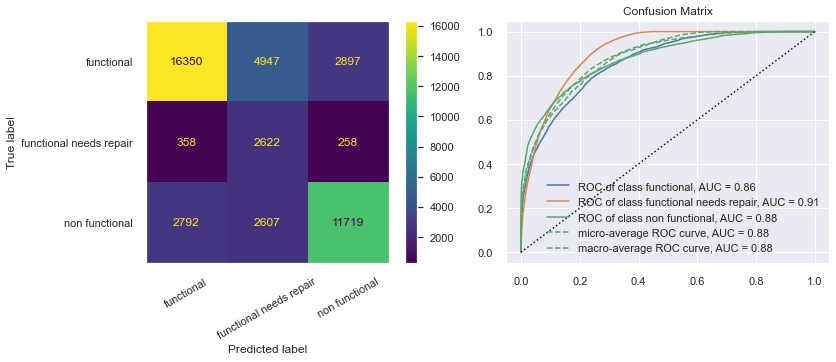

In [78]:
functions.cat_models(columns_1, X_train_cat, y_train_cat)

#### Since we're looking at our Recall score we are concerned with the values in the bottom left hand corner showing 358 (middle left column) and 2792 (bottom left column). We will try to drop these values to lower these values as much as possible going forward. 

#### Next we will add additional columns and see how are model performs.

In [79]:
columns_2 = ['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group']

Recall Score: 0.7785554166495784
Precision Score: 0.6803394160713818
F1 Score: 0.6858160728684385
Cross Val Score: [0.67913047 0.67408504 0.67626952]
Mean Cross Val Score: 0.676495010133646


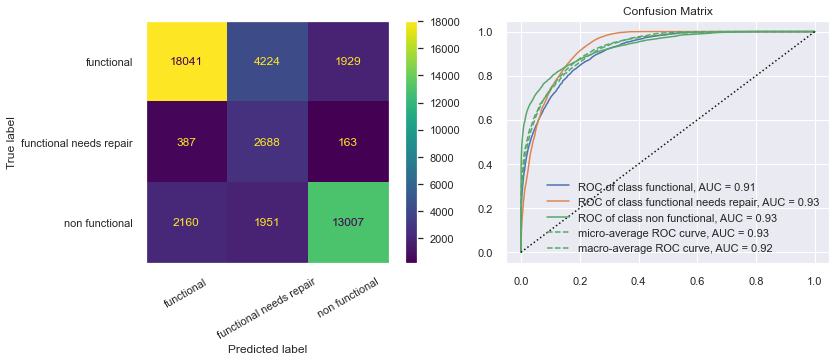

In [80]:
functions.cat_models(columns_2, X_train_cat, y_train_cat)

#### Improvement! Our AUC scores all went up and all of our values in our confusion matrix rose or fell in the correct spots. You can see that the values that we are concerned with dropped in the far bottom left but rose in the left middle.

#### Finally we will add all of the categorical features and see how our model performs.

In [81]:
columns_3 = ['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
                   'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
                  'extraction_type_group', 'extraction_type_class','management',\
                   'management_group', 'payment', 'payment_type', 'water_quality',\
                  'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                   'source_class', 'waterpoint_type', 'waterpoint_type_group']

Recall Score: 0.8574625931393763
Precision Score: 0.7558249872146746
F1 Score: 0.779425214154133
Cross Val Score: [0.6761367  0.67967339 0.67518257]
Mean Cross Val Score: 0.6769975537880647


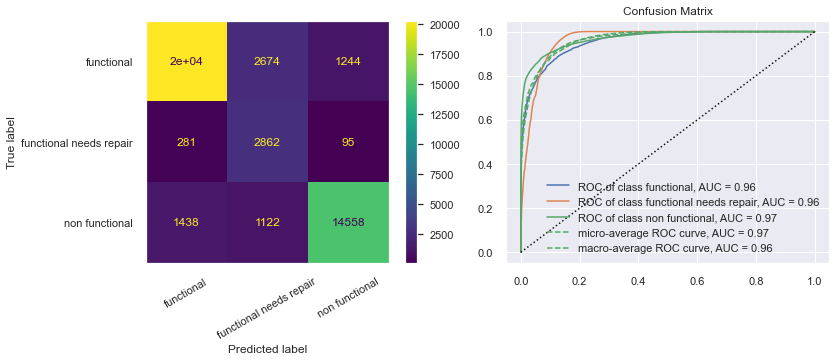

In [82]:
functions.cat_models(columns_3, X_train_cat, y_train_cat)

#### This model is performing really well on our test data but we maybe starting to overfit our model as seen in the cross val scores being the same as model # 2. Moving forward use model # 2. 

### Categorical & Numerical Data

### Finally we will build a pipeline to incorporate our numberical data and categorical data from model # 2.

In [83]:
X = df_mode[['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group',\
                 'longitude', 'latitude', 'construction_year']]

y = df_mode['status_group']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

Recall Score: 0.9943618993760062
Precision Score: 0.975886872764026
F1 Score: 0.9847501151376267
Cross Val Score: [0.65418761 0.6619801  0.65147399]
Mean Cross Val Score: 0.6558805685583337


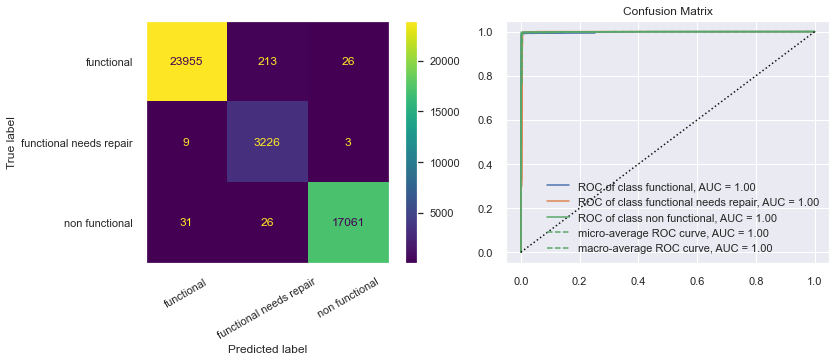

In [84]:
numeric_features = ['construction_year','longitude', 'latitude']
categorical_features = ['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group']
functions.pipe_rfc(numeric_features, categorical_features, X_train, y_train)

### Oofff overfit and our cross val scores dropped from model # 2. Lets what happens when we remove some numeric variables.

Recall Score: 0.9943756768966034
Precision Score: 0.9759063685465467
F1 Score: 0.98476679234574
Cross Val Score: [0.65049472 0.66269374 0.64803508]
Mean Cross Val Score: 0.6537411824844862


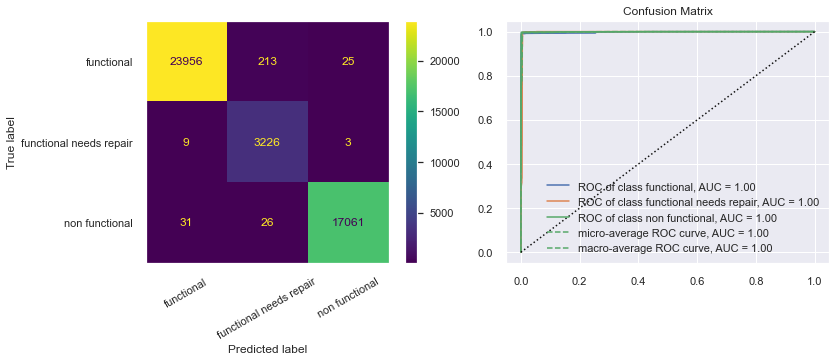

In [85]:
numeric_features = ['latitude','longitude']
categorical_features = ['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group']
functions.pipe_rfc(numeric_features, categorical_features, X_train, y_train)

#### Looks like our model dropped again. Lets try to tune our first pipeline and model # 2 and see what our results are.

#### Grid Search Model # 2

In [86]:
# # Initiallize OHE
# ohe = OneHotEncoder(drop = 'first')
    
# # Create wanted dataframe
# df_feat = X_train[columns_2]
    
# # Fit transform categorical columns
# df_feat_enc = ohe.fit_transform(df_feat)
    
# # Instantiate classifier
# rfc = RandomForestClassifier(random_state=42)
   
# #Fit Classifier
# rfc.fit(df_feat_enc, y_train)

In [87]:
# param_grid = {
#  'max_depth': [3,10, None],
#  'criterion': ['gini', 'entropy'],
#  'min_samples_leaf': [1, 2, 4],
#  'n_estimators': [100, 500],
#  'class_weight': ['balanced', 'balanced_subsample'],
#  'n_jobs': [-1]
# }

# grid_search = GridSearchCV(rfc, param_grid, n_jobs=-1, scoring='recall_macro', cv = 3, return_train_score=True)

# grid_search.fit(df_feat_enc, y_train)

In [88]:
# with open('saved_code/grid_search_cat_model_2', 'wb') as f:
#     pickle.dump(grid_search, f)

In [89]:
with open('saved_code/grid_search_cat_model_2', 'rb') as f:
    grid_search = pickle.load(f)

#### Grid Search Numeric Model # 1

In [90]:
num_feats = ['construction_year','longitude', 'latitude']
cat_feats = ['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group']

# Create Numberic Transformer
numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
# Create Categorical transformer
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
# Create Preprossor
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_feats),
            ('cat', categorical_transformer, cat_feats)])

# Create Pipeline
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state = 42, class_weight= 'balanced', n_jobs = -1))])

# Fit Model
rfc.fit(X_train, y_train)
 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['construction_year',
                                                   'longitude', 'latitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['source_type', 'region',
                                                   'district_code',
                                                   'public_meeting',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
             

In [91]:
        
# param_grid = {
#  'classifier__max_depth': [3,10, None],
#  'classifier__criterion': ['gini', 'entropy'],
#  'classifier__min_samples_leaf': [1, 2, 4],
#  'classifier__n_estimators': [100, 500],
#  'classifier__class_weight': ['balanced', 'balanced_subsample'],
#  'classifier__n_jobs': [-1]
# }

# grid_search_2 = GridSearchCV(rfc, param_grid, n_jobs=-1, scoring='recall_macro', cv = 3, return_train_score=True)

# grid_search_2.fit(X_train, y_train)

In [92]:
# with open('saved_code/grid_search_num_model_1', 'wb') as f:
#     pickle.dump(grid_search_2, f)

In [93]:
with open('saved_code/grid_search_num_model_1', 'rb') as f:
    grid_search_2 = pickle.load(f)

### Feature Selection

In [94]:
feat_import_nam = list(rfc.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=cat_feats))
feat_import_nam = feat_import_nam + num_feats
feat_import_num = grid_search_2.best_estimator_.named_steps['classifier'].feature_importances_
feat_import = pd.DataFrame(feat_import_num, index=feat_import_nam)

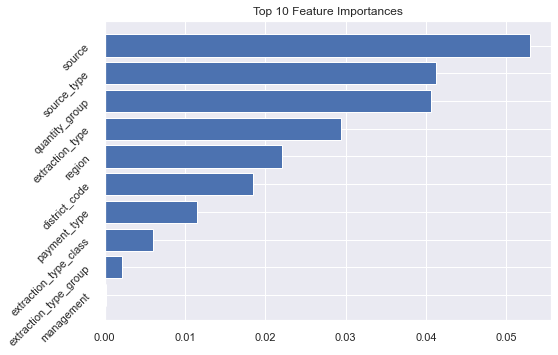

In [95]:
feat_import_name = []
feat_import_value = []

for name in cat_feats+num_feats:
    total = 0
    avg = 0
    for i in range(len(feat_import_num)):
        if name in feat_import_nam[i]:
            avg += 1
            total += feat_import_num[i]
            
    feat_import_name.append(name)
    feat_import_value.append(total)
    
feat_import = pd.DataFrame(feat_import_value, index=feat_import_name)
feat_import.sort_values(0, inplace=True)



plt.barh(list(feat_import.index[-10:]), feat_import[0].head(10).values)
plt.xticks()
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances')
plt.savefig('saved_objects/feat_import');

## Final Scores

### Model # 2

In [96]:
# Initiallize OHE
ohe = OneHotEncoder(drop = 'first')
    
# Create wanted dataframe
df_feat = X_test[columns_2]
    
# Fit transform categorical columns
df_feat_enc_test = ohe.fit_transform(df_feat)

grid_search_yhat = grid_search.predict(df_feat_enc_test)

Recall Score: 0.7038307064046395
Precision Score: 0.6277811467871036
F1 Score: 0.6264131058423547
Cross Val Score: [0.65749388 0.66547731 0.65762611]
Mean Cross Val Score: 0.6601991015082623


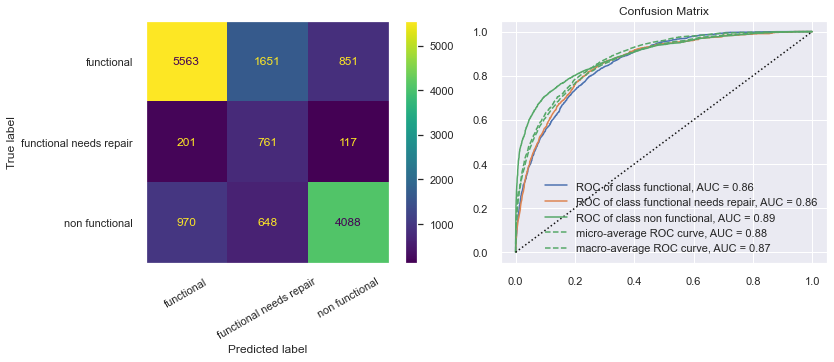

In [97]:
functions.scoring(df_feat_enc_test, y_test, grid_search)

### Numerical and Categorical Model

Recall Score: 0.7243185079575575
Precision Score: 0.6550372866253692
F1 Score: 0.6641691425090365
Cross Val Score: [0.66978695 0.66832472 0.68045661]
Mean Cross Val Score: 0.6728560931016002


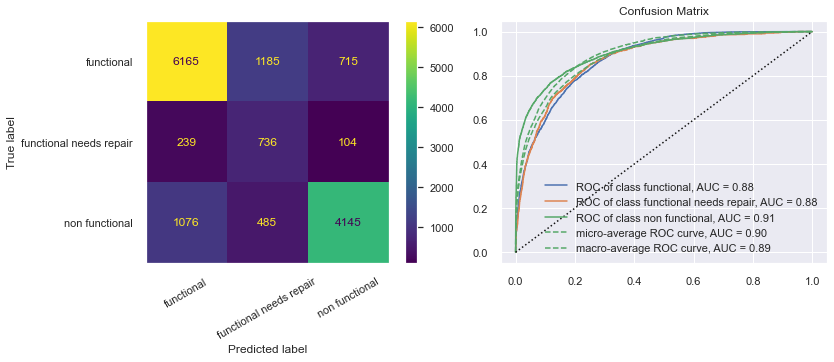

In [98]:
functions.scoring(X_test, y_test, grid_search_2)

# Our Numeric & Categorical Model is our WINNER!

### Online Submission

In [99]:
submission = pd.read_csv('data/Test_set.csv')

In [100]:
num_feats = ['longitude', 'latitude', 'construction_year']
cat_feats = ['source_type','region','district_code','public_meeting','extraction_type','extraction_type_group',\
             'extraction_type_class','management','payment_type','quantity_group','source','source_class','waterpoint_type_group']

submission = submission[cat_feats+num_feats]

In [101]:
final_submit = grid_search_2.predict(submission)

In [102]:
final_submit = pd.DataFrame(final_submit)
id_col = pd.DataFrame(submission_1['id'])
final_submit.columns = ['status_group']


NameError: name 'submission_1' is not defined

In [ ]:
id_col.reset_index(drop=True, inplace=True)

In [ ]:
id_col

In [ ]:
final_submit = pd.concat([id_col, final_submit], axis = 1)
final_submit.reset_index(drop=True, inplace=True)

In [ ]:
final_submit.iloc[:,1:]

In [ ]:
final_submit.iloc[:,1:].to_csv('final_submit.csv', index_label='id')